<center><img src="logo.png" alt="logo" style="float:center; width:200px;"/></center>

<center><h1 style="color:rgb(49,112,223);"> Interactive Decision Trees</h1><\center>

# 

# Using Interactive Decision Trees to ensure physical consistency of the DT by manually changing leaves nodes classes and/or variables and thresholds to split in cases of Imbalanced datasets   

In this JupyterLab notebook we show how experts can manually change  leaves nodes classes and/or variables and thresholds to split. We demonstrate how this functionality of the iDTs toolbox could be used to icorporate scientific knowledge into DT and ensure physical consistency. The methodology described in this JupyterLab notebook was followed to produce the results of the 3rd case study of the paper *Integrating Scientific Knowledge into Machine Learning using Interactive Decision Trees (Sarailidis et al. 2021, submitted to Computers and Geosciences)*.

# Notebook Contents:

1. Introduction
    + 1.1 Objective of the case study
    + 1.2 Description of the initial dataset
2. Steps followed to create imbalanced datasets of various sizes
3. Derive the Statistically Optimal Tree (SOT)
4. Interacting with the DT to tackle the problem of missing class C2
5. Evaluation of DTs
6. References

# 1. Introduction:

## 1.1 Objective of the case study 
This case study is an example of application of interactive DT (iDT) in cases where certain classes are under-represented in a dataset (a situation known as imbalanced datasets). Statistically optimal DT in cases like this may miss important classes because classifying data points in other classes may give better results satistically. However, such DT may not generalize well on unseen data where all classes are well represented. The objective here is to show that by interacting with the DT (by manually changing variables and thresholds to split and leaf node classes) the experts can ensure that important classes will appear in the DT even if they are under-represented and iDT can generalize better on unseen data.

To do that we create random samples of various sizes with imbalanced representation of classes (Section 2). Then we derive SOT (Section 3) and iDT (Section 4) for each of the imbalanced datasets. Finally, we evaluate the DT (SOT and iDTs) based on their classification performance and physical consistency. 

## 1.2 Description of the initial dataset:

We used the dataset from Sarazin (2018): 

- The dataset contains 17,000,000 simulations data points of a hydrological model and 34 input variables which characterize climate properties and land cover types. 
- There are 4 classes in the dataset, namely, C1 (<20 mm/yr), C2 (20 – 100 mm/yr), C3 (100 – 300 mm/yr) and C4 (>300 mm/yr) which correspond to different recharge values.
- A DT algorithm applied to this dataset shows how the different input variables combine to produce more or less recharge. 

# 2. Steps followed to create imbalanced datasets of various sizes

1. Create sample datasets of 5 different sizes ([1000,34], [5000,34], [10000,34], [50000,34], [100000,34]) by random sampling from the initial dataset described above and splitting into training and test sets (75% and 25% of the dataset size respectively). 
        
    __Note_1:__ The 5 sample datasets of various sizes were created using the GUI for importing files we developed and it's included in iDTGUIfun module. It contains an implementation for random sampling and splitting in train and test sets. To ease reproducibility, in the rest of this notebook I will use the sample dataset I derived (and which are provided in the folder 'Sample_dataset') to produce the results of the 3rd case study of the paper *Integrating Scientific Knowledge into Machine Learning using Interactive Decision Trees Sarailidis et al. (2021) submitted to Computers and Geosciences*

     __Note_2:__ If interested to know how to use the import file GUI please look at the "How to use the Graphical User Interface" pdf I provide in the repository and the 1st_case_study Workflow.

1. Find and store the indexes of data points that belong to a certain class to variables with corresponding names 
2. We remove data points that belong to C2 class.
3. Remove the class label and the corresponding colour from the classes color dictionary
4. From the initial training set we randomly sample data points that belong to C2 class and store it in a variable. The length of that variable is such that when it will be concatenated with the variable that contains the data points without C2 class the resulting training set will contain only few data points of class C2 (<2%).
5. We concatenate the variable that contains only data points of C2 class (which however are very few) with the variable that contains no data points of C2 class. The resulting training set will contain only few data points of class C2 (<2%) while the test set has a more balanced representation of the classes.
6. Restore the class label and the corresponding colour in classes color dictionary

In [4]:
#Import library for random sampling
import random
#Import modules for interactive construction and analysis of DT
import InteractiveDT
from InteractiveDT import iDT
from InteractiveDT import iDTGUIfun

In [5]:
#The next three empty dictionaries we create are required as inputs for the initialization of the GUI
Data_dict={}
Classes_color_dict={'Classes Labels': {}, 'Classes Colors': {}}
Features_color_groups={'Groups & parameters': {}, 'Colors of groups': {}}
#Initialize the GUI:
GUI = iDTGUIfun.InteractiveDecisionTreesGUI(Data_dict, Classes_color_dict, Features_color_groups)
#Initializa the GUI for importing dataset
GUI.ImportDatasetGUI()

# 

## *Sample dataset [5000, 34]:*

Import necessary libraries & modules

In [6]:
#Libraries which are useful for many cases
import pandas as pd
import numpy as np
#Libraries necessary for data analysis and ML methods
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
#Libraries useful for finding the statistiaclly optimal trees
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
#Libraries useful for measuring the classification accuracy and creating confusion matrices
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Libraries necessary for producing the plots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Load the corresponding dataset:

In [9]:
#Store the paths the data live in variables
path_train_inputs = 'Sample_datasets/Sample_5000/Inputs_updated_C2_smpl_5000'
path_train_outputs = 'Sample_datasets/Sample_5000/Outputs_updated_C2_smpl_5000'
path_test_inputs = 'Sample_datasets/Sample_5000/Inputs_test_C2_smpl_5000'
path_test_outputs = 'Sample_datasets/Sample_5000/Outputs_test_C2_smpl_5000'


#Train set Input features
GUI.Data_dict['x']=pd.read_pickle(path_train_inputs)
#Train set Outputs (classes)
GUI.Data_dict['y']=pd.read_pickle(path_train_outputs)
#Test set Input features
GUI.Data_dict['z']=pd.read_pickle(path_test_inputs)
#Test set Outputs (classes)
GUI.Data_dict['w']=pd.read_pickle(path_test_outputs)
#Features labels
GUI.Data_dict['features']=list(Data_dict['x'].columns)

#Complete output dataset
GUI.Data_dict['outputs_complete_dataset']=pd.concat([GUI.Data_dict['y'], GUI.Data_dict['w']])
#Complete inputs dataset
GUI.Data_dict['inputs_complete_dataset']=pd.concat([GUI.Data_dict['x'], GUI.Data_dict['z']])
#Outputs training dataset
GUI.Data_dict['outputs_train']=GUI.Data_dict['y']
#List of available features (variables) in the dataset
GUI.Data_dict['features']=list(GUI.Data_dict['x'].columns)

Now we need to create the dictionary that will store the classes names and the corresponding colours. We use the DefineClassesGUI for this purpose. In the GUI that will appear:

+ Type the name of the class in the correspodning text area widget that will appear.
     - The names of the classes should be the same as the ones included in the csv file we imported. For this example the classes names are: C1, C2, C3, C4
+ Click the 'Add Class Label' button
+ Click on the colored box to open the color picker box. Pick a color and click ok. Or, type the name of the colour in the corresponding text area of the widget. 
+ Click the 'Assign color to the Class' button

In [10]:
GUI.DefineClassesGUI()
GUI.classes_labels_box

__Note:__ If someone wants to see the loaded classes and colours then in a new cell type GUI.classes_dict and run the cell. This will output a dictionary which stores key-value pairs of classes labels and classes colours.

### Create the imbalance datasets:
### Step 2.2 Store the indexes of data points that belong to a certain class to variables with corresponding names

In [6]:
C4_indexes = list(GUI.Data_dict['y'][GUI.Data_dict['y']=='C4'].index)
C3_indexes = list(GUI.Data_dict['y'][GUI.Data_dict['y']=='C3'].index)
C2_indexes = list(GUI.Data_dict['y'][GUI.Data_dict['y']=='C2'].index)
C1_indexes = list(GUI.Data_dict['y'][GUI.Data_dict['y']=='C1'].index)

### Step 2.3 Removing data points that belong to C2 class.

In [7]:
Inputs_C2_missing = GUI.Data_dict['x'].drop(C2_indexes)
Outputs_C2_missing = GUI.Data_dict['y'].drop(C2_indexes)

### Step 2.4 Remove the class label and the corresponding colour from the dictionary

In [8]:
del GUI.classes_dict['Classes Labels'][1]
del GUI.classes_dict['Classes Colors'][1]

### Step 2.5 Random sampling of C2 data points and store them in a variable

In [9]:
sample_C2=GUI.Data_dict['x'].loc[C2_indexes,:].sample(int(0.016*len(Inputs_C2_missing)))

### Step 2.6 Concatenate the two variables to create one training imbalanced dataset

In [10]:
Inputs_updated_C2=pd.concat([Inputs_C2_missing, sample_C2])
Outputs_updated_C2=pd.concat([Outputs_C2_missing, GUI.Data_dict['y'][sample_C2.index]])

GUI.Data_dict['x'] = Inputs_updated_C2
GUI.Data_dict['y'] = Outputs_updated_C2

### Step 2.7 Restore the class label and the corresponding colour in the color classes dictionary

In [11]:
GUI.classes_dict['Classes Labels'].insert(1, 'C2')
GUI.classes_dict['Classes Colors'].insert(1, '#288638')

# 3. Derive the Statistically Optimal Tree (SOT)

In this section I describe the methodology followed to derive the Statistically optimal tree (SOT) for each sample dataset.

Exhaustive Grid Search from sklearn library (for more details: https://scikit-learn.org/0.15/modules/grid_search.html ) was used to determine the optimal values of certain tree building parameters. Using these optimal values when fitting the tree will give us the SOT.

1. We set up the parameter space grid with the following parameters (and their ranges):

    + Max_leaf_nodes: [15:26 (or 30 in large samples), step=1]


2. We set a 10-fold Cross validation search

In Exhaustive Grid Search all the possible combinations of parameter values are evaluated, and the best combination is retained.

In [12]:
#Create a Decision Tree classifier object
dtc = sklearn.tree.DecisionTreeClassifier(random_state=None)
#Variable range
max_leaf_nodes_range=list(range(10,20,1))
#Set up the parameter grid
parameter_grid = {'max_leaf_nodes': max_leaf_nodes_range}
#Set up the evaluation strategy
cross_validation = StratifiedKFold(n_splits=10)
# n_iter_search=20

#Exhaustive GridSearch
grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=cross_validation, n_jobs=-1, error_score='raise')

# grid_search.fit(Inputs_updated_C2, Outputs_updated_C2)
grid_search.fit(GUI.Data_dict['x'], GUI.Data_dict['y'])
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

#Fit a tree with the stat. optimal combination found
toy_tree_updated_C2 = grid_search.best_estimator_
# toy_tree_updated_C2.fit(Inputs_updated_C2, Outputs_updated_C2);
toy_tree_updated_C2.fit(GUI.Data_dict['x'], GUI.Data_dict['y']);

Best score: 0.8459387159533074
Best parameters: {'max_leaf_nodes': 15}


# 

If we specify the optimal pamaeter values as obtained from the exhaustive grid search to the corresponding widgets of the GUI that will appear we will get the SOT tree:

 + max_leaf_nodes = 15
 + The max_depth widget value shoulde be set to a high enough value (e.g. 10) to ensure that the 15 leaf node will be plotted. 
 + The max_features widget value should be set equal to number of features available in the dataset (in this case 34) in order for the algorithm to be able to choose among all of them. 
 + The rest of the parameters can be left at their default values. 
 
__Note_1:__ Once the user changes the value of one of 'Decision Tree Structure Controlling Parameters and Plot Formatting' widgets the DT plot will be automatically updated.

__Note_2:__ The max_depth widget value shoulde be set to a high enough value (e.g. 10) to ensure that the 15 leaf nodes will be plotted. Moreover, the max_features widget value should be set equal to number of features available in the dataset (in this case 34) in order for the algorithm to be able to choose among all of them.

In [13]:
#Initialize the GUI that contains widgets for interactive construction and analysis of DT
GUI.InterConAnalDTGUI()

#For the update Features button to work we need to initialize the GUI SelectFeaturesGUI.
GUI.SelectFeaturesGUI() 

#Output the widgets:
GUI.Box

interactive(children=(Dropdown(description='criterion', layout=Layout(width='20%'), options=('gini', 'entropy'…

VBox(box_style='info', children=(VBox(children=(HBox(children=(Label(value='Creation of New Composite Variable…

# 4. Derive expert guided DT to tackle the problem of missing class C2

The SOT misses the under-represented class C2 because the algorithm finds that classifying the data points of the dataset to the the rest of the classes as more optimal in a statistical sense. But we know that C2 is an important class and should be represented in the DT. Having the SOT as a starting point we interact with the DT in the following ways to fix this problem:

1. Manually change nodes threshold and variables to split
2. Manually change leaf nodes classes
3. Manually prune redudant nodes

The above interactions enable the experts to input their expert knowledge and tackle the issue of missing classes. We know based on our experience with this dataset that in the left part of the tree (with reference to the root node) the DT should lead at some leaves of class C2. Therefore, we try to play with the variables and thresholds to split until we manage to get leaves with C2 class. Or, directly change a leaf node class to C2 if we know it makes more sense to be C2.

### 4.1 Manually change nodes threshold and variables to split:

1. In the widget 'Node_id', specify the id of the node we want to change its threshold. The user can see the nodes IDs by hovering over the nodes in the plot (a window displaying the ID, the impurity and the nodes samples appears).
2. Select the variable to split from the dropdown menu of the widget named 'Features'.
3. Specify the new threshold value in the widget named 'Split Point'
4. Specify the max_leaf_nodes the left subtree should have 'Max_leaf_nodes_right_subtree'
5. Specify the max_leaf_nodes the right subtree should have in the widget named 'Max_leaf_nodes_right_subtree'   
6. Press the button widget 'Apply Changes'.
  
__Note_1:__ If we want to make changes to a node which in the original SOT one of its barnches leads to a leaf node e.g. left branch, then for this node for the left_subtree we need to specify max_leaf_nodes_left_subtree = 2, because otherwise the program won't work. Then, we can manually prune that node if we want to force it to have one leaf_node as in the original SOT.

We repeat the above steps until we are happy. In this case study we make the following changes in the following order:

1. Node 0:  From Pm <= 233.05  to     Pm <= 720    (Max_leaf_nodes_left_subtree = 11, Max_leaf_nodes_right_subtree = 4) -> With this change we essentially make node 2 of the original SOT tree the root node to iDT.
    
2. Node 1:  From Pm <= 233.05  to     Pm <= 300    (Max_leaf_nodes_left_subtree = 4, Max_leaf_nodes_right_subtree = 8)

3. Node 2:  From Pm <= 188.155 to     Pm <= 65     (Max_leaf_nodes_left_subtree = 2, Max_leaf_nodes_right_subtree = 2) -> If we make a split on that node on Pm<65 we are confident that for Pm<=65 some instances are classified as C2. Even if the algorithm won't give us a leaf node with C2 class we can manually change that.

4. Node 17: From Pm <= 639.075 to     Pm <= 500    (Max_leaf_nodes_left_subtree = 2, Max_leaf_nodes_right_subtree = 2) 

5. Node 18: From Dp <= 1.667   to ro_P_E <= -0.4   (Max_leaf_nodes_left_subtree = 2, Max_leaf_nodes_right_subtree = 2) -> We are confident that one of the resulting nodes from that split should contain instances of class C2. Even if the algorithm doesn't dive a leaf node of class C2 we can change that later.

6. Node 18: From  a <= 1.889   to     Ip <= 7.00   (Max_leaf_nodes_left_subtree = 2, Max_leaf_nodes_right_subtree = 2)

7. Node 29: From  a <= 2.26    to      a <= 1.6    (Max_leaf_nodes_left_subtree = 2, Max_leaf_nodes_right_subtree = 2)


__Note:__ Everytime we make a change to a node and we press the 'Apply Changes' button the nodes numbering will be updated in the derived tree. So in the above list the node ids refer to the last modified tree.


### 4.2 Manually prune redudant nodes 


To manually prune nodes using the GUI we follow the steps:

1. Check the 'Tree is Modified' widget because we previously modified the DT by manually changing the threshold values.
2. Specify node id to be pruned in the 'Node to prune' widget
3. Press the 'Prune' button

We repeat steps 2 to 3 until we are happy. In this case study we prune the following nodes in the following order:

1. Node: 10 (of the last modified tree)
2. Node: 3  (of the last pruned tree)
3. Node: 29 (of the last pruned tree)
4. Node: 15 (of the last pruned tree)
5. Node: 16 (of the last pruned tree)
6. Node: 9 (of the last pruned tree)


__Note:__ Everytime we make a change to a node and we press the 'Prune' button the nodes numbering will be updated in the derived tree.


### 4.3 Manually change leaf nodes classes

To manually change the leaves nodes classes using the GUI we follow the steps:

1. Select whether the tree was last modified (e.g. variable or threshold to split was changed) or pruned from the dropdown menu widget named 'Tree State'. In this example, select 'Last pruned'.
2. Specify the node id (numbering of nodes is based on the last modified or pruned) using the text area widget named 'Leaf Node ID'.
3. Specify the new class of the leaf node using the text area widget named 'Class'
4. Press the 'Change Class' button.

We repeat the above steps untial we are happy. In this case study we make the following nodes in the following order:

1. Leaf node 9:  From C1 to C2
2. Leaf node 14: From C3 to C2
3. Leaf node 23: From C3 to C2

In [14]:
#Output the widgets:
GUI.Box

VBox(box_style='info', children=(VBox(children=(HBox(children=(Label(value='Creation of New Composite Variable…

# 5. Evaluating the DTs

The evaluation of SOT and iDT is based on the following criteria:

1. Classification accuracy on the training and test sets
2. Missing or not class C2

### Assessment of the classification performance

In the GUI that will appear the user should:

+ Specify the tree state using the dropdown widget:
    - If there were no previous interactions with the DT then the user should select the 'No expert tree interactions'. In this example, by selecting this, the accuracies for the SOT will be calculated.
    - If the last interaction with the DT was manual changing of variable and/or threshold to split then the user should select the option 'Tree was last modified'
    - If the last interaction with the DT was manual pruning then the user needs to select the option 'Tree was last pruned'. In this example, by selecting this, the accuracies for the iDT will be calculated.
+ Make sure the 'Train_test_splitting' is checked.
+ Then click on the 'Calculate accuracy' button (In the case of iDT it will take few minutes)

In [15]:
#Output the evaluation widgets
GUI.Eval_box

VBox(box_style='info', children=(VBox(box_style='info', children=(HBox(box_style='info', children=(Dropdown(de…

__Note: For the rest of the sample datasets of the paper I applied the same methodology to all the 5 different sample datasets.__

Having applied the same methodology for each of the sample datasets and measuring the classification accuracy on train and tests set, we can plot them into as lines:

In [16]:
data_acc={'Stat_Optimal_Trees_train':    [0.894, 0.867, 0.872, 0.866, 0.866],
          'Stat_Optimal_Trees_test':     [0.584, 0.578, 0.576, 0.594, 0.596],
          'iDT_train': [0.743, 0.693, 0.774, 0.841, 0.816],
          'iDT_test':  [0.652, 0.706, 0.642, 0.625, 0.620],
          'Tick_labels': [1, 2, 3, 4, 5]}
acc_df=pd.DataFrame(data_acc)

We use the the Scatter Plot from plotly python Graphic Libraries to create the line charts

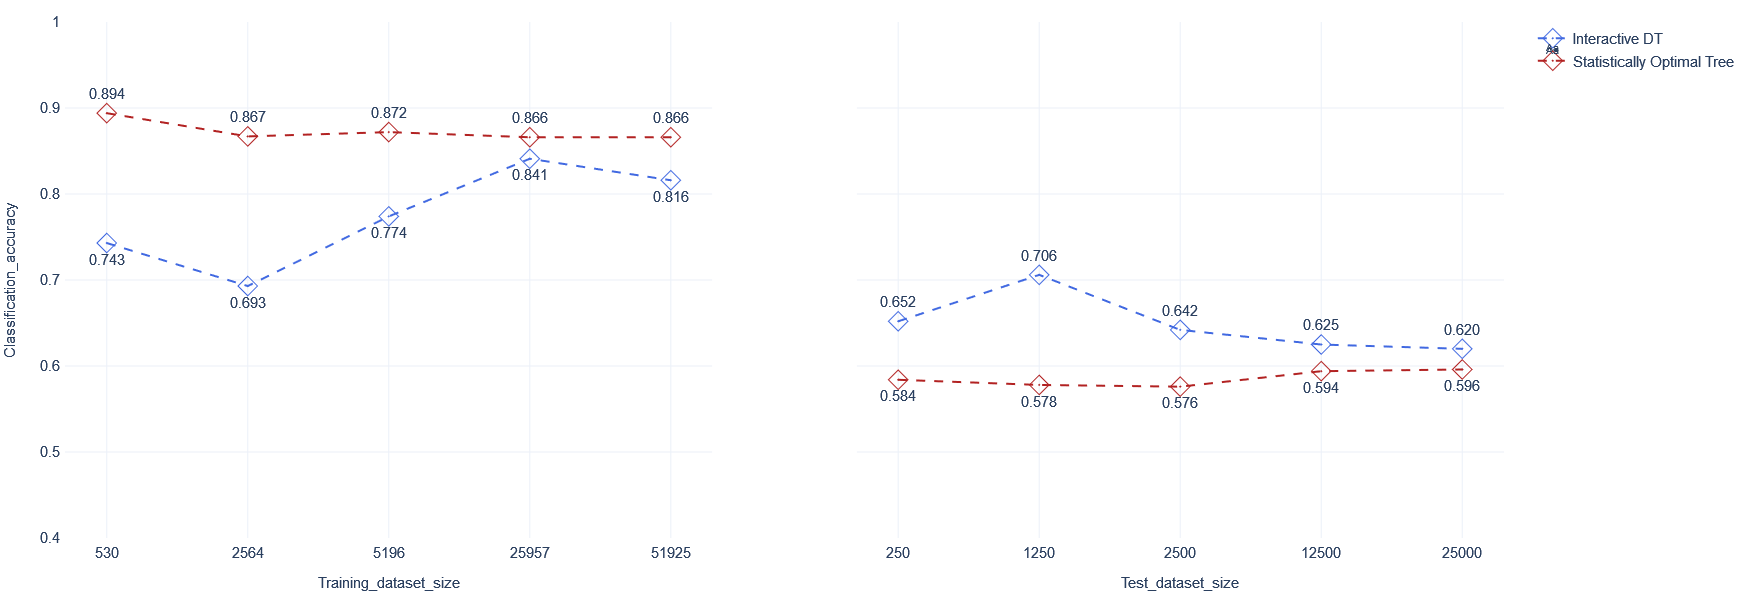

In [17]:
#Create a figure with one row and 2 columns to plot the line charts for the train and test set
Acc_fig = make_subplots(rows=1, cols=2, shared_yaxes=True)

#Store some info about the formatting of the graphs in variables
line_width = 2
textfont_size = 15
marker_size = 15
plot_width = 1200 
plot_height = 600
legend_fontsize = 15
axis_font_and_tick_size = 15

Acc_fig.append_trace(go.Scatter(x=data_acc['Tick_labels'], y=data_acc['iDT_train'], 
                                mode='lines+markers+text',
                                line = dict(color='royalblue', width=line_width, dash='dash'),
                                marker_symbol='diamond-open-dot',
                                name='Interactive DT',   
                                text=data_acc['iDT_train'],
                                textposition='bottom center',
                                textfont={'family':'Arial', 'size':textfont_size},
                                texttemplate='%{text:.3f}',
                                marker=dict(color='royalblue', size=marker_size)), row=1, col=1)

Acc_fig.append_trace(go.Scatter(x=data_acc['Tick_labels'], y=data_acc['Stat_Optimal_Trees_train'],
                                mode='lines+markers+text',
                                line = dict(color='firebrick', width=line_width, dash='dash'),
                                marker_symbol='diamond-open-dot',
                                name='Statistically Optimal Tree', 
                                text=data_acc['Stat_Optimal_Trees_train'],
                                textposition='top center', 
                                textfont={'family':'Arial', 'size':textfont_size},
                                texttemplate='%{text:.3f}',
                                marker=dict(color='firebrick', size=marker_size)), row=1, col=1)

Acc_fig.append_trace(go.Scatter(x=data_acc['Tick_labels'], y=data_acc['iDT_test'],
                                mode='lines+markers+text',
                                line = dict(color='royalblue', width=line_width, dash='dash'),
                                marker_symbol='diamond-open-dot',
                                name='Interactive DT - Test set',
                                text=data_acc['iDT_test'],
                                textposition='top center',
                                textfont={'family':'Arial', 'size':textfont_size},
                                texttemplate='%{text:.3f}',
                                showlegend=False,
                                marker=dict(color='royalblue', size=marker_size)), row=1, col=2)

Acc_fig.append_trace(go.Scatter(x=data_acc['Tick_labels'], y=data_acc['Stat_Optimal_Trees_test'],
                                mode='lines+markers+text',
                                line = dict(color='firebrick', width=line_width, dash='dash'),
                                marker_symbol='diamond-open-dot',
                                name='Stat. Opt. Tree - Test set',
                                text=data_acc['Stat_Optimal_Trees_test'],
                                textposition='bottom center', 
                                textfont={'family':'Arial', 'size':textfont_size},
                                texttemplate='%{text:.3f}',
                                showlegend=False,
                                marker=dict(color='firebrick', size=marker_size)), row=1, col=2)


Acc_fig.update_layout(autosize=False, width=plot_width, height=plot_height,
                      legend = dict(font={'family':'Arial', 'size':legend_fontsize}, orientation='v'),
                      margin = go.layout.Margin(l=20,r=20,b=20,t=20,pad = 4), template='plotly_white')

Acc_fig.update_xaxes(title_text='Training_dataset_size', tickmode = 'array', tickvals=[1,2,3,4,5], ticktext=['530', '2564', '5196', '25957', '51925'],
                     titlefont={'family':'Arial','size':axis_font_and_tick_size}, tickfont={'family':'Arial', 'size':axis_font_and_tick_size}, row=1, col=1),
Acc_fig.update_xaxes(title_text='Test_dataset_size', tickmode = 'array', tickvals=[1,2,3,4,5], ticktext=['250', '1250', '2500', '12500', '25000'],
                     titlefont={'family':'Arial','size':axis_font_and_tick_size}, tickfont={'family':'Arial','size':axis_font_and_tick_size}, row=1, col=2)

Acc_fig.update_yaxes(title_text='Classification_accuracy', titlefont={'family':'Arial', 'size':axis_font_and_tick_size}, tickfont={'family':'Arial', 'size':axis_font_and_tick_size}, range=[0.4, 1], row=1, col=1)

We can show how the 4 classes are represented in each dataset (training and test for the various samples) in a colored bar and by assigning what percentage each class corresponds to the overall dataset

- Classes Representation - Training Set:

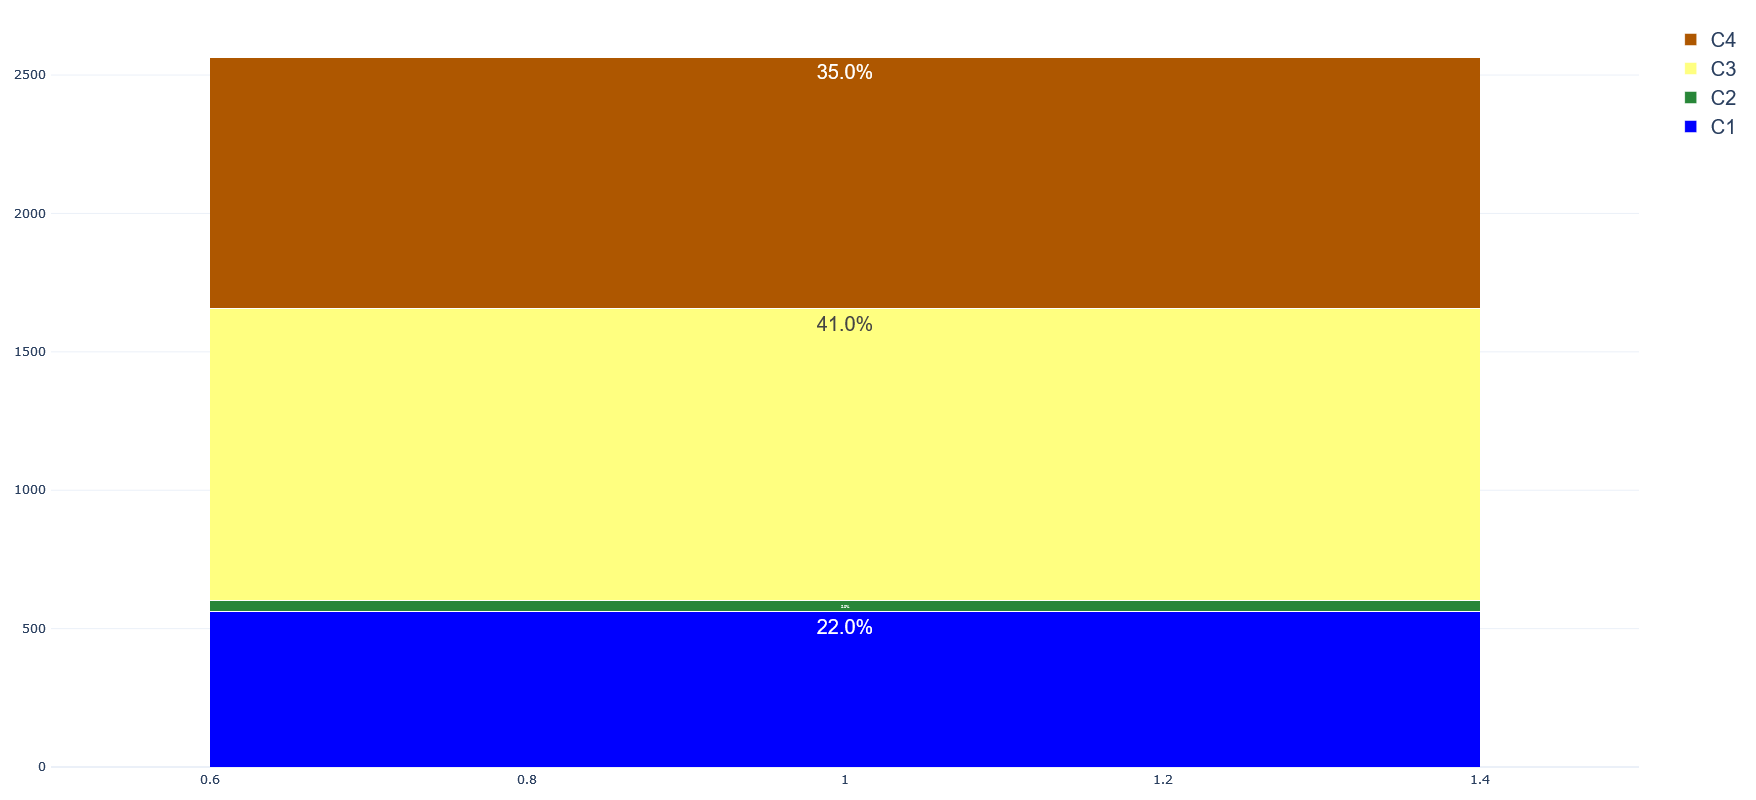

In [18]:
import plotly.graph_objects as go
class_dist_train = go.Figure()
class_dist_train.add_trace(go.Bar(x=[1], y=np.array(len(GUI.Data_dict['y'][GUI.Data_dict['y'] == 'C1'])), text="{}%".format(round((len(GUI.Data_dict['y'][GUI.Data_dict['y'] == 'C1'])/len(GUI.Data_dict['y']))*100,0)), 
                     textposition='auto', textfont={'family':'Arial', 'size':20}, marker_color='blue', name='C1' )) #, text='C1', ,
class_dist_train.add_trace(go.Bar(x=[1], y=np.array(len(GUI.Data_dict['y'][GUI.Data_dict['y'] == 'C2'])), text="{}%".format(round((len(GUI.Data_dict['y'][GUI.Data_dict['y'] == 'C2'])/len(GUI.Data_dict['y']))*100,0)), 
                     textposition='auto', textfont={'family':'Arial', 'size':20}, marker_color='#288638', name='C2')) #name='C2', text='C2', textposition='auto'
class_dist_train.add_trace(go.Bar(x=[1], y=np.array(len(GUI.Data_dict['y'][GUI.Data_dict['y'] == 'C3'])), text="{}%".format(round((len(GUI.Data_dict['y'][GUI.Data_dict['y'] == 'C3'])/len(GUI.Data_dict['y']))*100,0)), 
                     textposition='auto', textfont={'family':'Arial', 'size':20}, marker_color='#ffff80', name='C3')) #name='C3', text='C3', textposition='auto'
class_dist_train.add_trace(go.Bar(x=[1], y=np.array(len(GUI.Data_dict['y'][GUI.Data_dict['y'] == 'C4'])), text="{}%".format(round((len(GUI.Data_dict['y'][GUI.Data_dict['y'] == 'C4'])/len(GUI.Data_dict['y']))*100,0)), 
                     textposition='auto', textfont={'family':'Arial', 'size':20}, marker_color='#ae5700', name='C4' )) #name='C4', text='C4', textposition='auto'
class_dist_train.update_layout(barmode='stack', autosize=False, width=400, height=800,
                      legend = dict(font={'family':'Arial', 'size':20}, orientation='v'),
                      margin = go.layout.Margin(l=20,r=20,b=20,t=20,pad = 4), template='plotly_white')

class_dist_train.update_traces(opacity=1)
class_dist_train.show()

- Classes distribution - Test Set

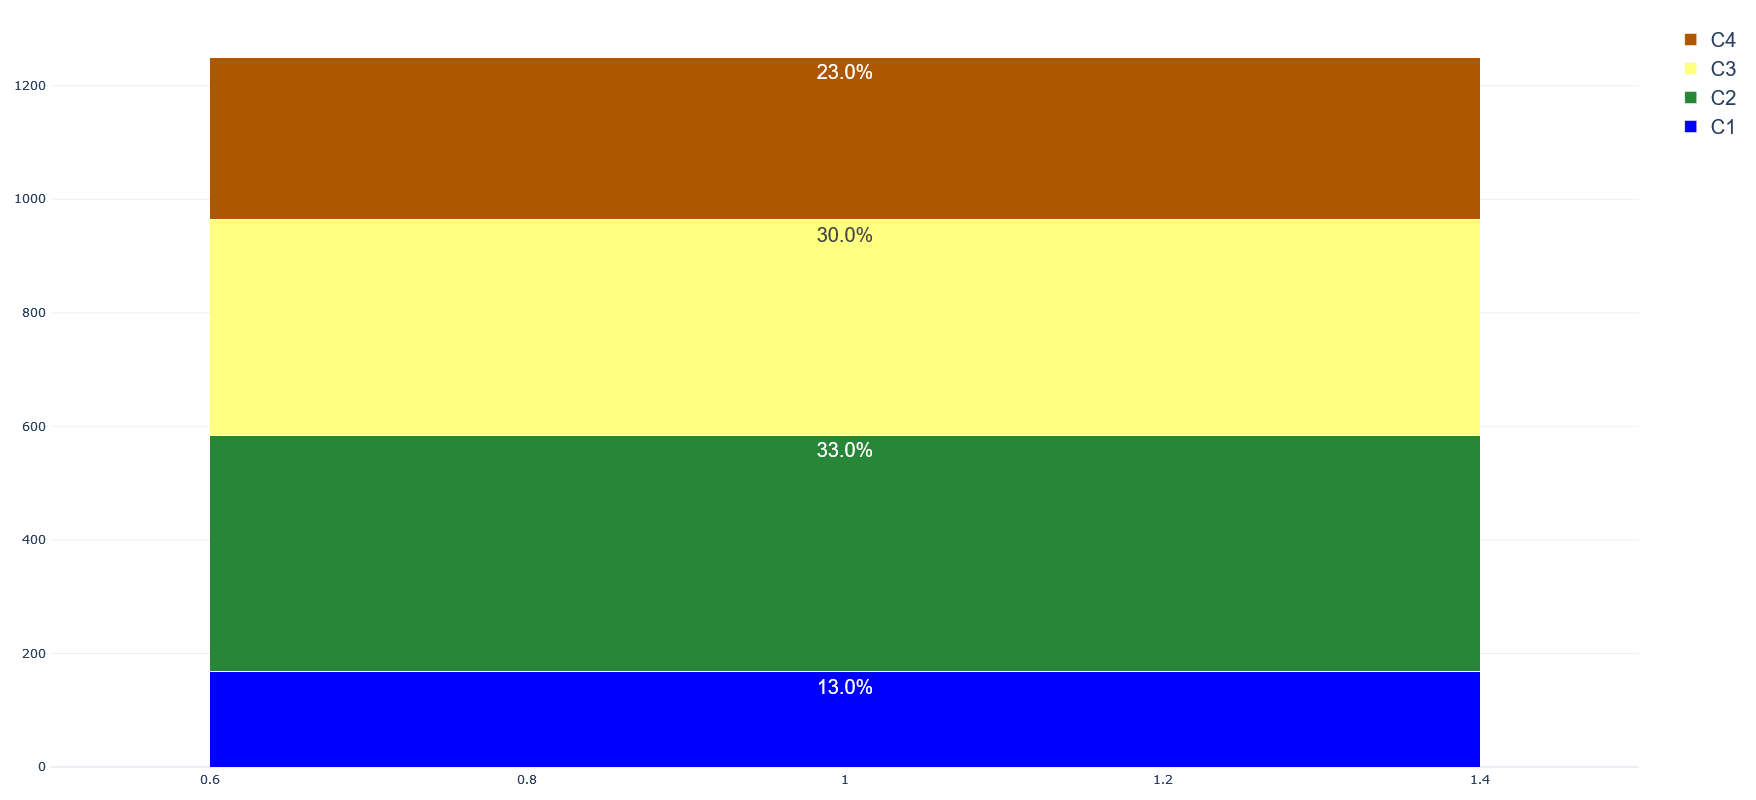

In [19]:
import plotly.graph_objects as go
class_dist_test = go.Figure()
class_dist_test.add_trace(go.Bar(x=[1], y=np.array(len(GUI.Data_dict['w'][GUI.Data_dict['w'] == 'C1'])), text="{}%".format(round((len(GUI.Data_dict['w'][GUI.Data_dict['w'] == 'C1'])/len(GUI.Data_dict['w']))*100,0)), 
                     textposition='auto', textfont={'family':'Arial', 'size':20}, marker_color='blue', name='C1' ))
class_dist_test.add_trace(go.Bar(x=[1], y=np.array(len(GUI.Data_dict['w'][GUI.Data_dict['w'] == 'C2'])), text="{}%".format(round((len(GUI.Data_dict['w'][GUI.Data_dict['w'] == 'C2'])/len(GUI.Data_dict['w']))*100,0)), 
                     textposition='auto', textfont={'family':'Arial', 'size':20}, marker_color='#288638', name='C2' ))
class_dist_test.add_trace(go.Bar(x=[1], y=np.array(len(GUI.Data_dict['w'][GUI.Data_dict['w'] == 'C3'])), text="{}%".format(round((len(GUI.Data_dict['w'][GUI.Data_dict['w'] == 'C3'])/len(GUI.Data_dict['w']))*100,0)), 
                     textposition='auto', textfont={'family':'Arial', 'size':20}, marker_color='#ffff80', name='C3' ))
class_dist_test.add_trace(go.Bar(x=[1], y=np.array(len(GUI.Data_dict['w'][GUI.Data_dict['w'] == 'C4'])), text="{}%".format(round((len(GUI.Data_dict['w'][GUI.Data_dict['w'] == 'C4'])/len(GUI.Data_dict['w']))*100,0)), 
                     textposition='auto', textfont={'family':'Arial', 'size':20}, marker_color='#ae5700', name='C4' ))
class_dist_test.update_layout(barmode='stack', autosize=False, width=400, height=800,
                      legend = dict(font={'family':'Arial', 'size':20}, orientation='v'),
                      margin = go.layout.Margin(l=20,r=20,b=20,t=20,pad = 4), template='plotly_white')

class_dist_test.update_traces(opacity=1)
class_dist_test.show()

__Note:__ The code used to produce the colored bars is the same for each sample dataset with the only difference being the input data.

# 6. References

- Understanding the sensitivity of karst groundwater recharge to climate and land cover changes at a large-scale, Sarrazin, F. (Author). 25 Sep 2018